# Imports

In [23]:
import time
import json
import os
import pickle


import pandas as pd
import numpy as np


import torch
print(torch.__version__)  # Should print a compatible version
print(torch.cuda.is_available())

import tsai
from tsai.basics import*


import matplotlib.pyplot as plt
%matplotlib inline

import lightning.pytorch as pl
from lightning.pytorch import Trainer
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import EncoderNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from lightning.pytorch.tuner import Tuner

import optuna
import plotly
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters





2.2.2+cu121
True


ModuleNotFoundError: No module named 'plotly'

# Data Loading

In [3]:
master_df = pd.read_csv("../Outputs/Data_Master.csv")

# EDA

In [3]:
master_df.columns

Index(['Date', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude',
       'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
       'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b'],
      dtype='object')

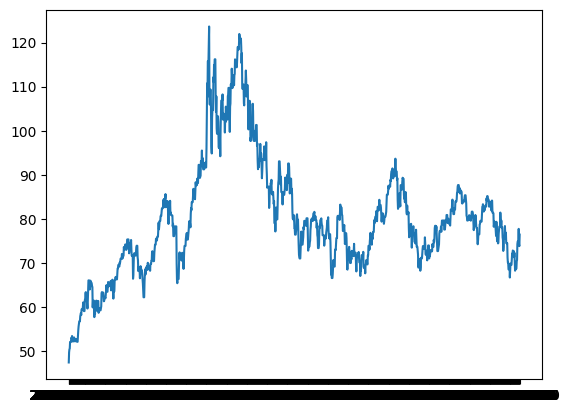

In [4]:
plt.plot(master_df['Date'], master_df['crude'])

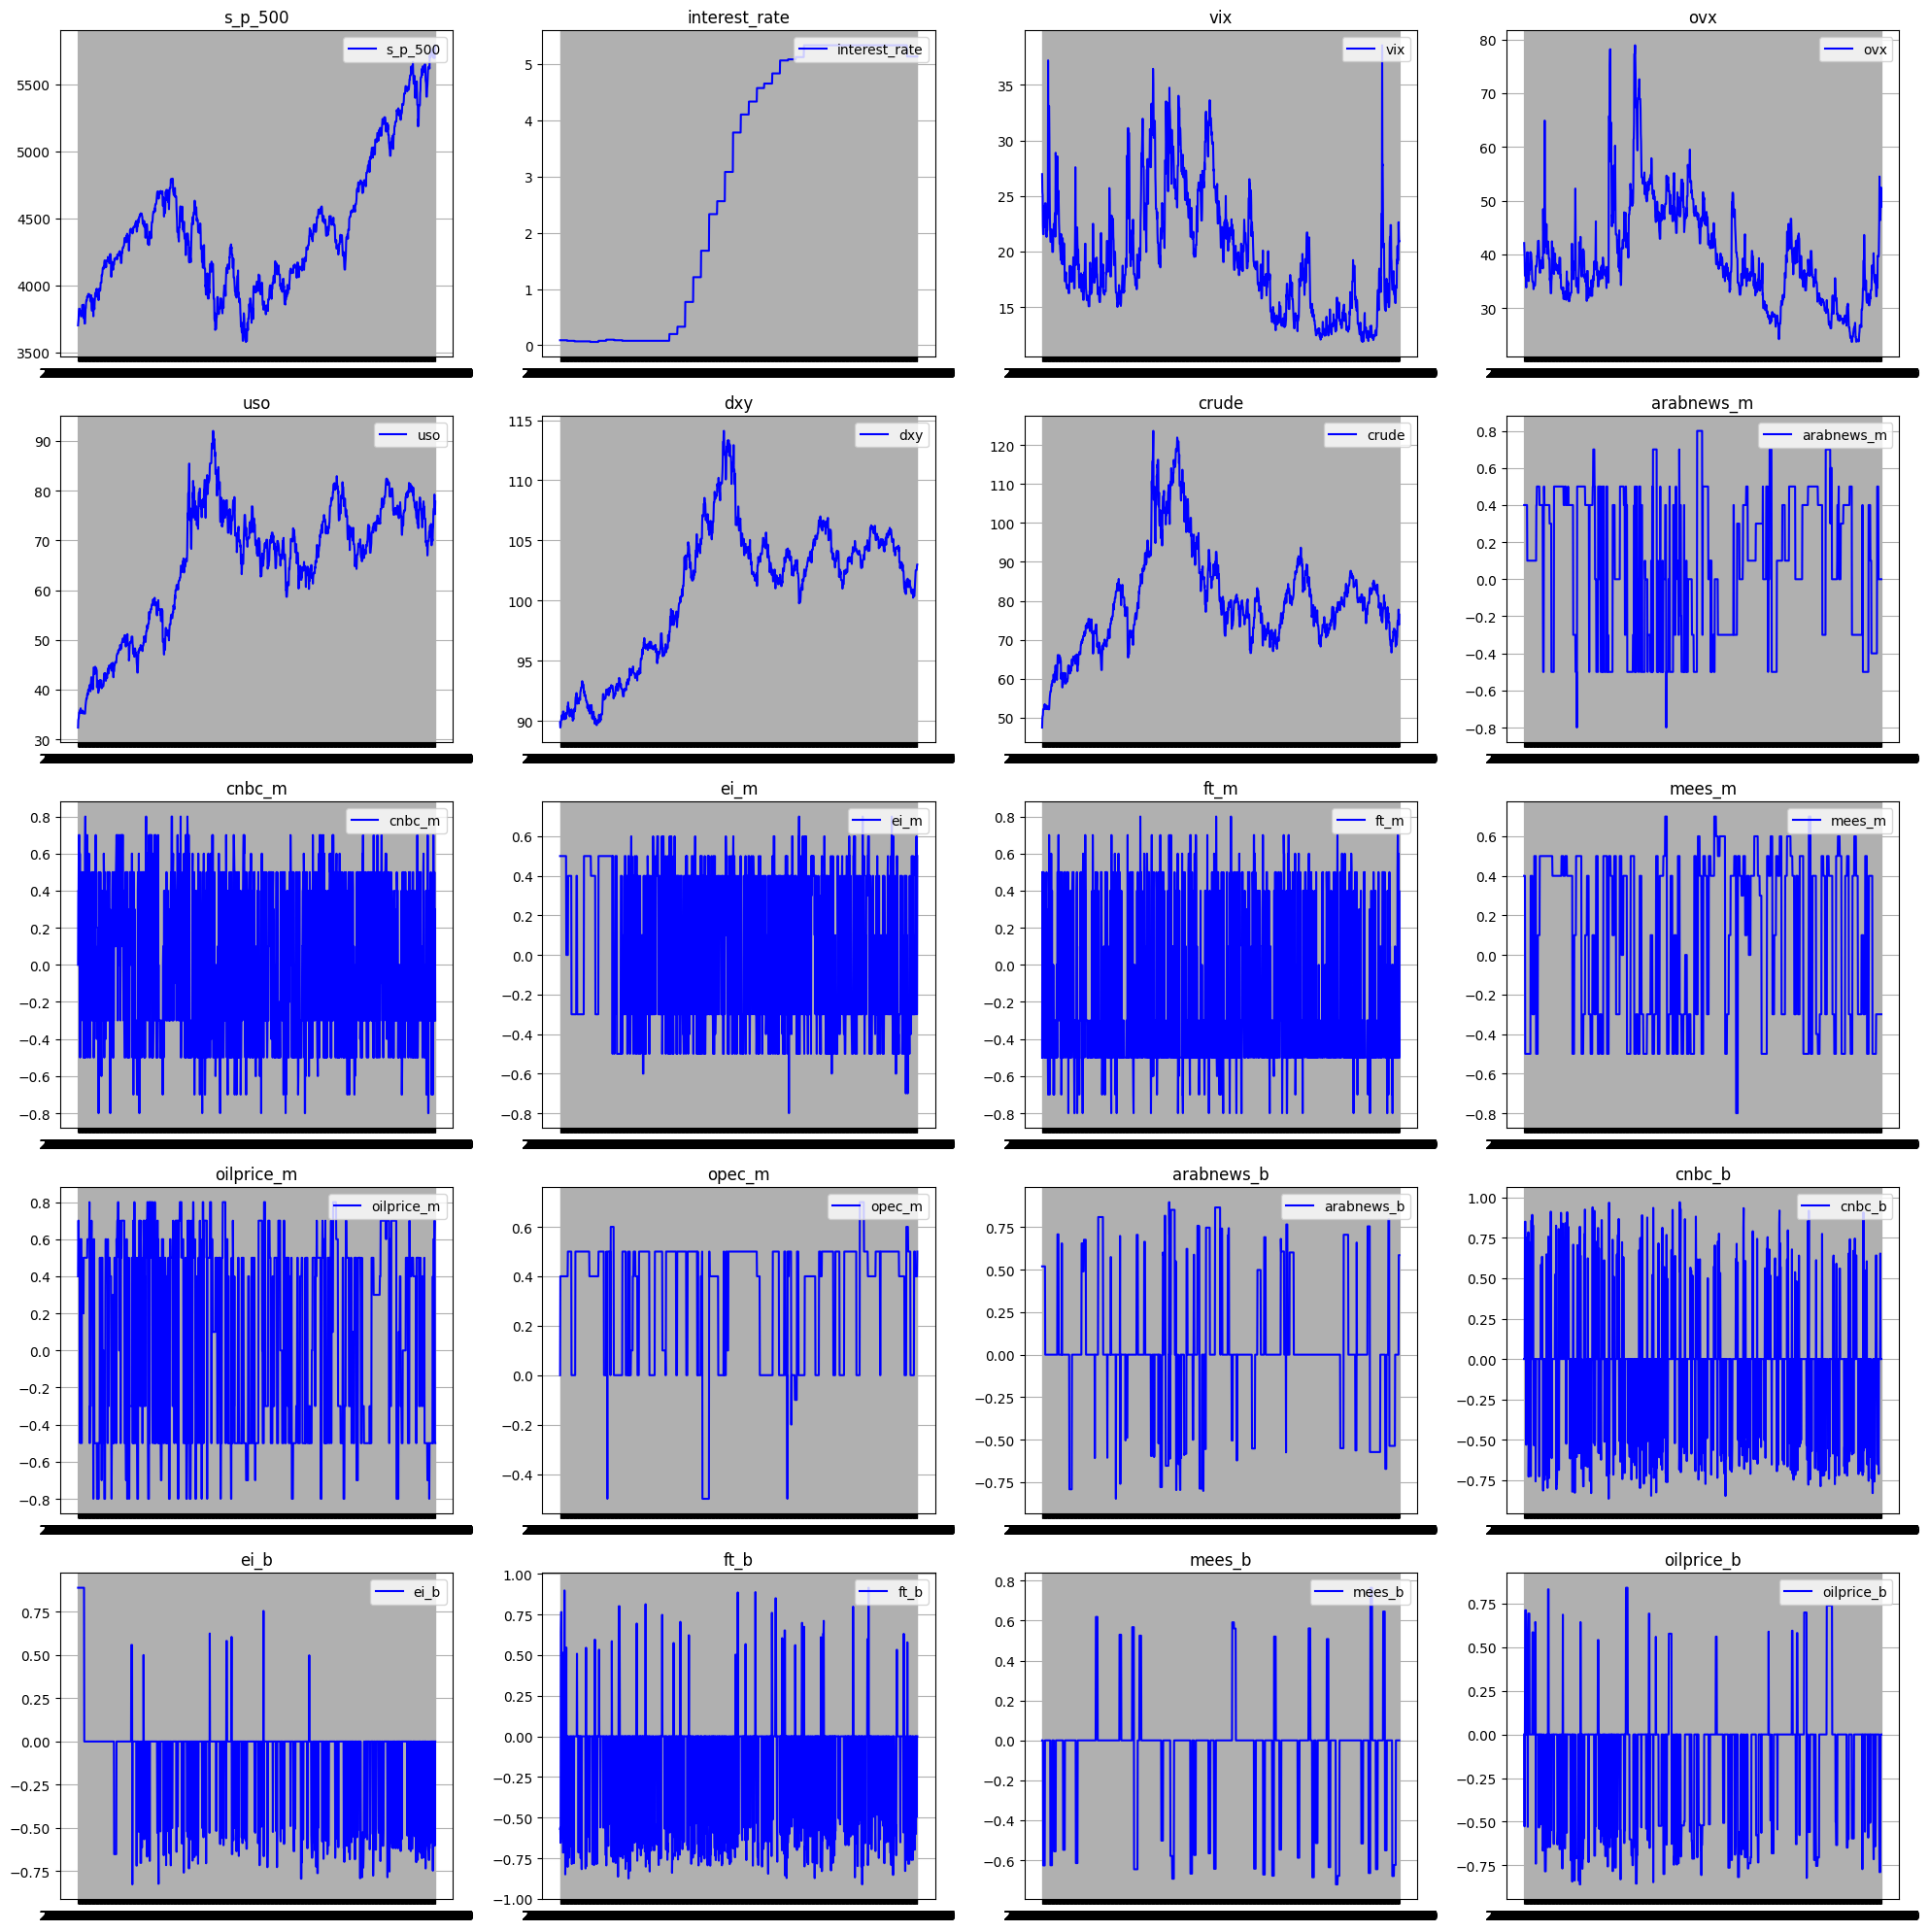

In [5]:
import matplotlib.pyplot as plt
import math

# List of variables to plot (excluding 'Date')
variables = [
    's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy', 'crude',
    'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
    'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
    'oilprice_b'
]

# Number of variables and layout configuration
num_vars = len(variables)
plots_per_row = 4
num_rows = math.ceil(num_vars / plots_per_row)

# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=plots_per_row, figsize=(20, num_rows * 4))

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot each variable
for i, var in enumerate(variables):
    axes[i].plot(master_df['Date'], master_df[var], label=var, color='blue')
    axes[i].set_title(var)
    axes[i].grid(True)
    axes[i].legend(loc='upper right')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Data Prep for Modelling

In [4]:
CALENDAR_CYCLES= {
    "weekday": 7,
    "week": 52,
    "month": 12,
}

In [5]:
def add_cyclical_calendar_features(df: pd.DataFrame, date_col: str, features: Union[str, List[str]]):
    """Cyclical encoding of calendar features based on a date column."""
    
    if isinstance(features, str):
        features = [features]

    # Ensure the date column is datetime
    df[date_col] = pd.to_datetime(df[date_col])

    for feat in features:
        assert (
            feat in CALENDAR_CYCLES.keys()
        ), f"Cyclical encoding is not available for {feat}"

        if feat == "week":
            # Use ISO calendar week
            values = df[date_col].dt.isocalendar().week
        else:
            # For other features (weekday, month), use .dt accessor
            values = getattr(df[date_col].dt, feat)

        # Apply cyclical encoding
        df[f"{feat}_sin"] = np.sin(2 * np.pi * values / CALENDAR_CYCLES[feat])
        df[f"{feat}_cos"] = np.cos(2 * np.pi * values / CALENDAR_CYCLES[feat])

    return df


In [6]:
master_df_processed = add_cyclical_calendar_features(master_df, 'Date', features=["weekday", "week", 'month'])
master_df_processed

,Date,s_p_500,interest_rate,vix,ovx,uso,dxy,crude,arabnews_m,cnbc_m,...,ei_b,ft_b,mees_b,oilprice_b,weekday_sin,weekday_cos,week_sin,week_cos,month_sin,month_cos
0,2021-01-04,3700.65,0.09,26.97,42.12,32.38,89.87,47.47,0.4,0.0,...,0.889924,-0.569241,0.000000,0.000000,0.000000,1.000000,0.120537,0.992709,0.500000,0.866025
1,2021-01-05,3726.86,0.09,25.34,40.39,33.94,89.44,49.78,0.4,0.4,...,0.889924,-0.560321,0.000000,-0.526396,0.781831,0.623490,0.120537,0.992709,0.500000,0.866025
2,2021-01-06,3748.14,0.09,25.07,39.31,34.11,89.53,50.45,0.4,0.4,...,0.889924,-0.654790,0.000000,-0.526396,0.974928,-0.222521,0.120537,0.992709,0.500000,0.866025
3,2021-01-07,3803.79,0.09,22.37,36.06,34.53,89.83,50.63,0.4,0.7,...,0.889924,0.644426,0.000000,0.000000,0.433884,-0.900969,0.120537,0.992709,0.500000,0.866025
4,2021-01-08,3824.68,0.09,21.56,36.65,35.43,90.10,52.14,0.4,0.7,...,0.889924,0.764327,-0.626426,0.711697,-0.433884,-0.900969,0.120537,0.992709,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,2024-10-06,5751.07,5.13,19.21,46.37,76.35,102.52,74.93,0.0,0.0,...,0.000000,0.000000,0.000000,-0.788622,-0.781831,0.623490,-0.992709,0.120537,-0.866025,0.500000
1372,2024-10-07,5695.94,5.13,22.64,48.32,79.20,102.54,77.76,0.0,0.5,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.970942,0.239316,-0.866025,0.500000
1373,2024-10-08,5751.13,5.13,21.42,52.35,75.79,102.55,74.26,0.0,-0.3,...,-0.603633,-0.496074,0.000000,0.000000,0.781831,0.623490,-0.970942,0.239316,-0.866025,0.500000
1374,2024-10-09,5792.04,5.13,20.86,48.80,75.25,102.93,73.85,0.0,0.3,...,0.000000,0.000000,0.000000,0.000000,0.974928,-0.222521,-0.970942,0.239316,-0.866025,0.500000


In [7]:
master_df_processed["weekend"] = (master_df_processed['Date'].dt.dayofweek > 4).astype(int)

In [42]:
split = round(len(master_df_processed)*0.8)
print(split)

train = master_df_processed.iloc[: split]
test = master_df_processed.iloc[split:]


1101


In [73]:
# datetime_col = 'Date'
# fcst_history = 50 # # steps in the past
# fcst_horizon = 16 # # steps in the future
# valid_size   = 0.1  # int or float indicating the size of the training set
# test_size    = 0.2  # int or float indicating the size of the test set

# splits = get_forecasting_splits(master_df_processed, fcst_history=fcst_history, fcst_horizon=fcst_horizon, datetime_col=datetime_col,
#                                 valid_size=valid_size, test_size=test_size)
# splits

# train_data = master_df_processed.iloc[splits[0]]
# test_data = master_df_processed.iloc[splits[2]]
# val_data = master_df_processed.iloc[splits[1]]

# print(train_data.shape)
# print(val_data.shape)
# print(test_data.shape)

In [43]:
train= train.reset_index()
train= (train.merge((train[['Date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['Date'])).drop(["Date"], axis=1)

test= test.reset_index()
test= (test.merge((test[['Date']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['Date'])).drop(["Date"], axis=1)

In [10]:
train.shape

(1101, 29)

In [44]:
constant_tr= [1 for item in train['vix']]
train['constant'] = constant_tr


In [45]:
constant_te= [1 for item in test['vix']]
test['constant'] = constant_te

# Model Building

In [6]:
max_encoder_length = 128 #history
max_prediction_length = 64 #forecast
training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


training_dataset = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="crude", # target variable
    max_encoder_length=max_encoder_length, # maximum size of lookup window
    max_prediction_length=max_prediction_length, # maximum size of horizon window
    group_ids = ['constant'], 
    time_varying_known_reals=[
        "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin', 'weekend'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
       'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
       'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b'], 
    target_normalizer=EncoderNormalizer(),
    lags={'crude': [7,365]}, # add lagged values of target variable
    predict_mode = True
)

NameError: name 'train' is not defined

In [46]:
max_encoder_length = 50
max_prediction_length = 16
training_cutoff = train["time_idx"].max() - max_prediction_length # validation on 2020


training_dataset = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="crude", # target variable
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    group_ids = ['constant'], 
    time_varying_known_reals=[
        "time_idx", 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin', 'weekend'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['crude', 's_p_500', 'interest_rate', 'vix', 'ovx', 'uso', 'dxy',
       'arabnews_m', 'cnbc_m', 'ei_m', 'ft_m', 'mees_m', 'oilprice_m',
       'opec_m', 'arabnews_b', 'cnbc_b', 'ei_b', 'ft_b', 'mees_b',
       'oilprice_b'], 
    target_normalizer=EncoderNormalizer(),
    lags={'crude': [7,365]}, # add lagged values of target variable
    predict_mode = True
)





In [47]:
validation_dataset = TimeSeriesDataSet.from_dataset(
  training_dataset, # dataset from which to copy parameters (encoders, scalers, ...)
  train, # data from which new dataset will be generated
  predict=True, # predict the decoder length on the last entries in the time index
  stop_randomization=True,
)

In [15]:
batch_size = 64  # set this between 32 to 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [16]:
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate= 0.001023292992280754 ,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8, 
    loss=MAE(),
    # logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

#0.0031622776601683794

Number of parameters in network: 38.7k


## LR Finder

In [21]:
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr:  95%|█████████▌| 95/100 [02:15<00:07,  1.43s/it]
LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.001023292992280754
Restoring states from the checkpoint path at /scratch/us2055/Oil_Price/Notebooks/.lr_find_c87e20c2-b207-4b8f-820a-bc41050650c0.ckpt
Restored all states from the checkpoint at /scratch/us2055/Oil_Price/Notebooks/.lr_find_c87e20c2-b207-4b8f-820a-bc41050650c0.ckpt


suggested learning rate: 0.001023292992280754


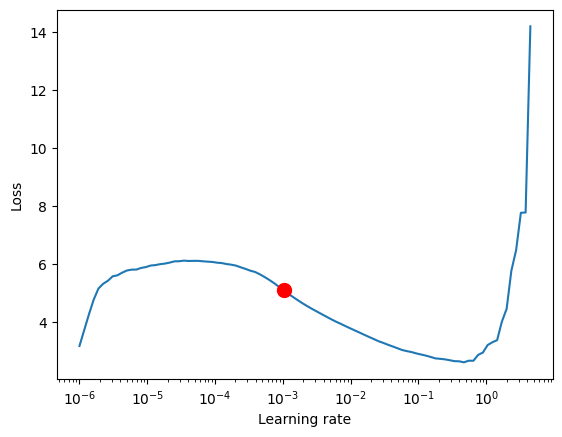

In [22]:
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

## Training

In [24]:
trainer = pl.Trainer(
    max_epochs=3,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    gradient_clip_val=0.1,
    
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [25]:
batch_size = 64  # set this between 32 to 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

In [26]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 464    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 528    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 20.0 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 4.4 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm |

Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  8.48it/s, v_num=5.4e+7, train_loss_step=5.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, v_num=5.4e+7, train_loss_step=5.110, val_loss=1.570, train_loss_epoch=5.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, v_num=5.4e+7, train_loss_step=4.000, val_loss=1.450, train_loss_epoch=5.110]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1/1 [00:01<00:00,  0.71it/s, v_num=5.4e+7, train_loss_step=4.000, val_loss=1.410, train_loss_epoch=4.000]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 1/1 [00:01<00:00,  0.66it/s, v_num=5.4e+7, train_loss_step=4.000, val_loss=1.410, train_loss_epoch=4.000]


In [27]:
predictions = tft.predict(val_dataloader, return_y=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


In [28]:
MAE()(predictions.output, predictions.y)

tensor(1.4131, device='cuda:0')

In [29]:
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


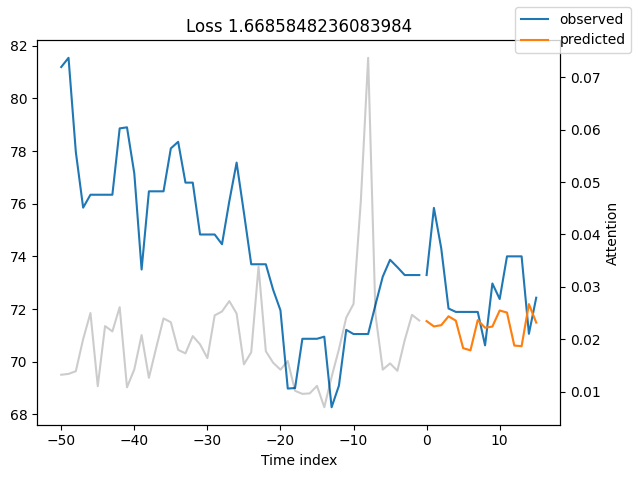

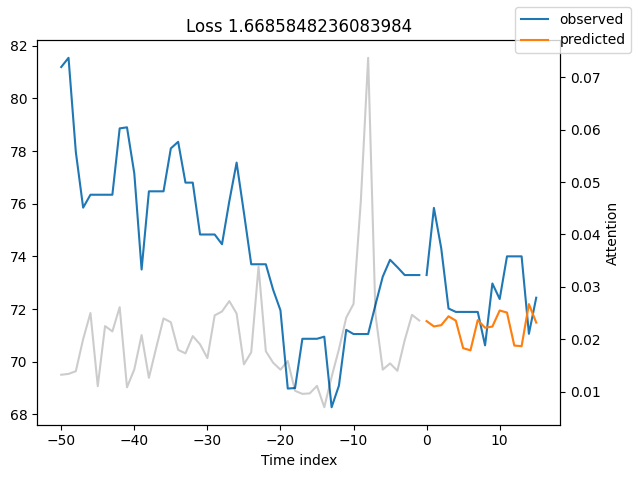

In [189]:
  # plot 10 examples
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx = 0, add_loss_to_title=True)

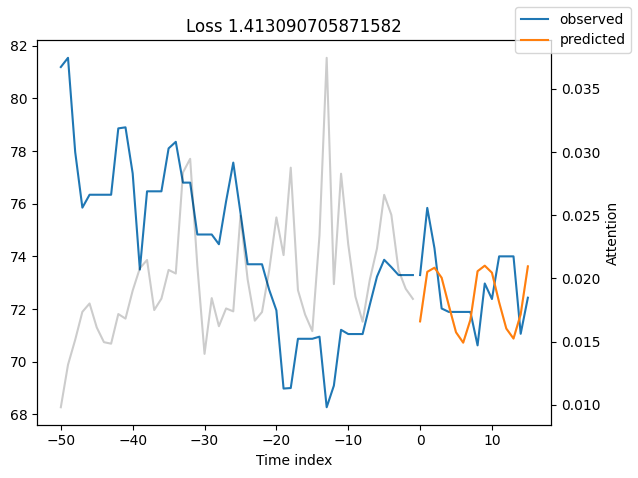

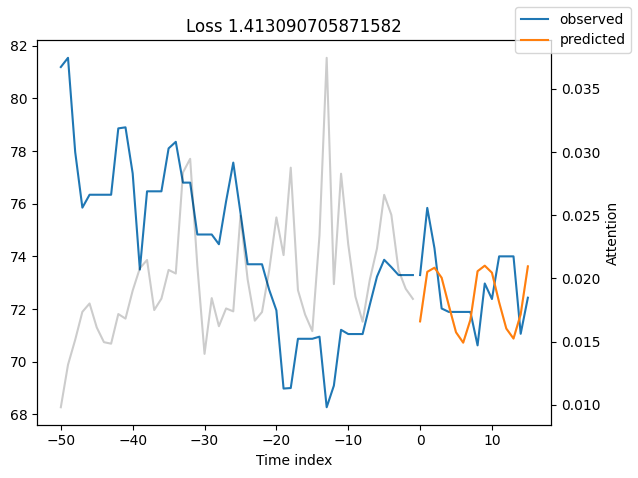

In [30]:
  # plot 10 examples
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx = 0, add_loss_to_title=True)

In [171]:
for idx in range(val_prediction_results.prediction.shape[0]): # nb of groups combinations
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax);

NameError: name 'val_prediction_results' is not defined

In [49]:
test["time_idx"]+=train["time_idx"].max()+1
test = pd.concat([train, test], ignore_index=True).fillna(0.0)

In [50]:
test_dataset = TimeSeriesDataSet.from_dataset(training_dataset,
                                        test, 
                                        predict=True, 
                                        stop_randomization=True)

# Create test dataloader
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=8)


In [33]:
test_preds = tft.predict(test_dataloader, return_y=True)
MAE()(test_preds.output, test_preds.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


tensor(2.9156, device='cuda:0')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


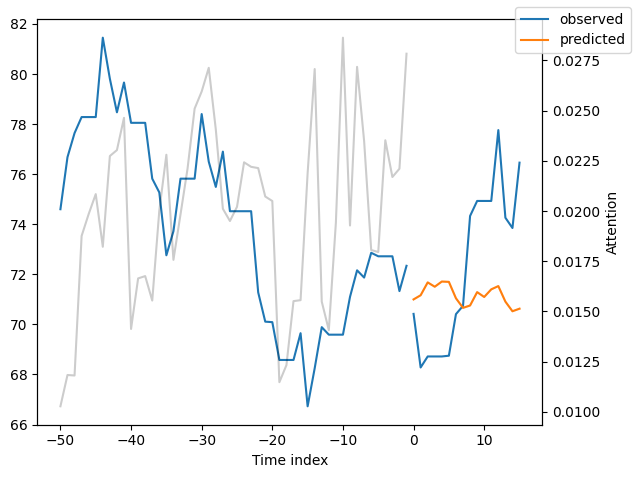

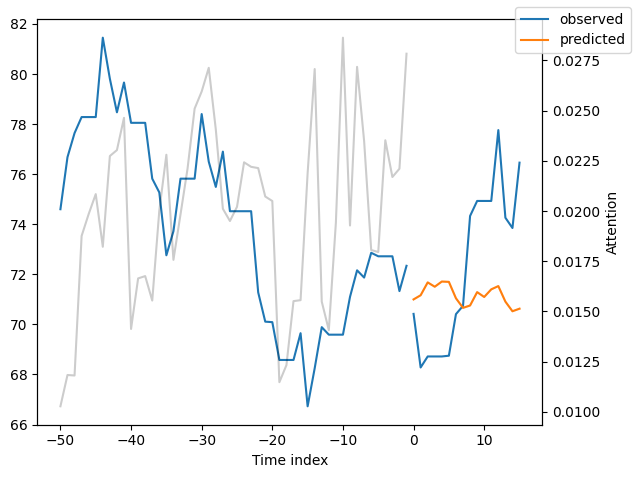

In [194]:
new_raw_predictions = tft.predict(test, mode="raw", return_x=True)

  # plot 10 examples
tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


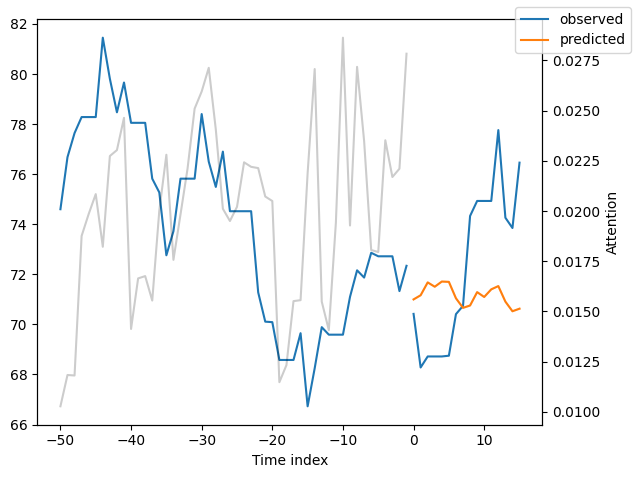

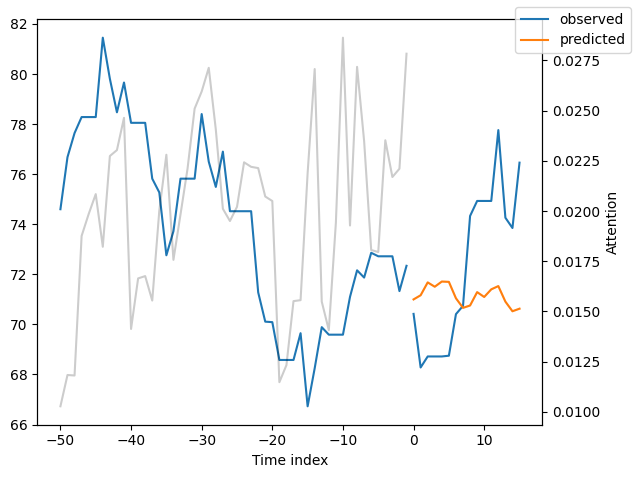

In [195]:
new_raw_predictions = tft.predict(test, mode="raw", return_x=True)

  # plot 10 examples
tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output, idx=0, show_future_observed=True)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x225 with 1 Axes>,
 'encoder_variables': <Figure size 700x900 with 1 Axes>,
 'decoder_variables': <Figure size 700x375 with 1 Axes>}

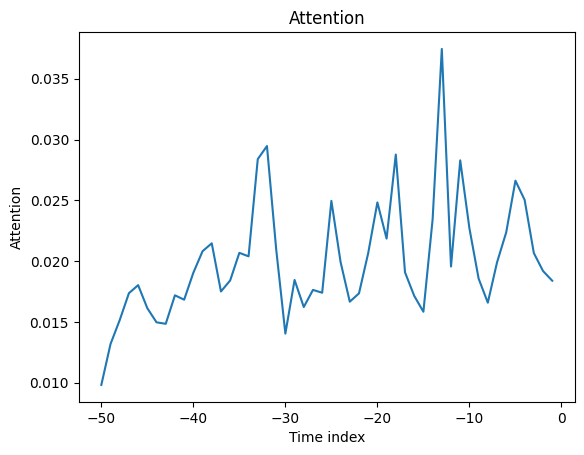

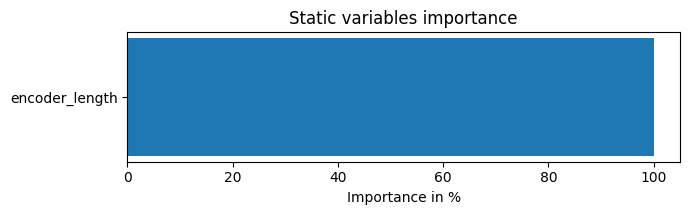

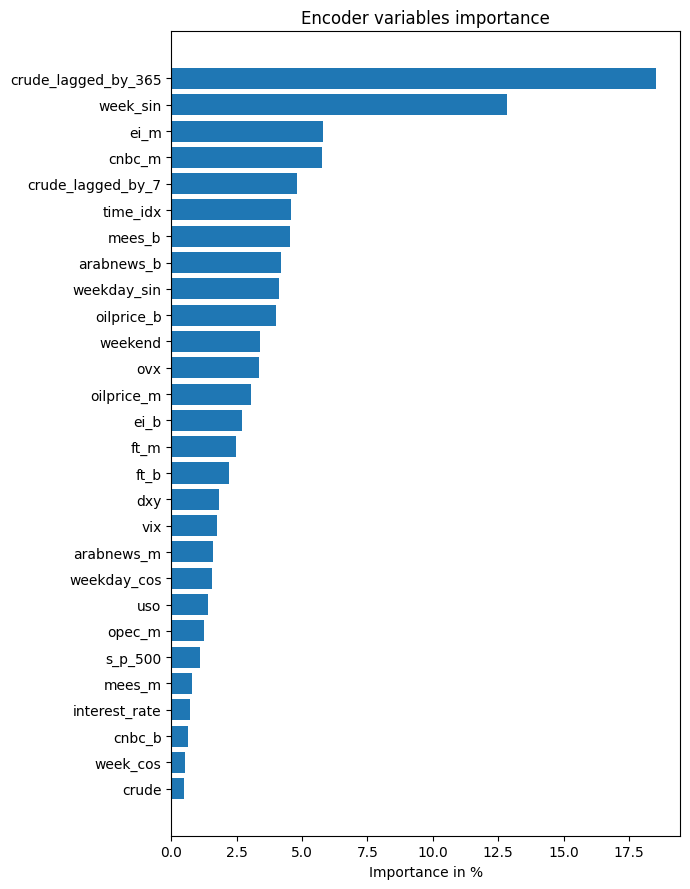

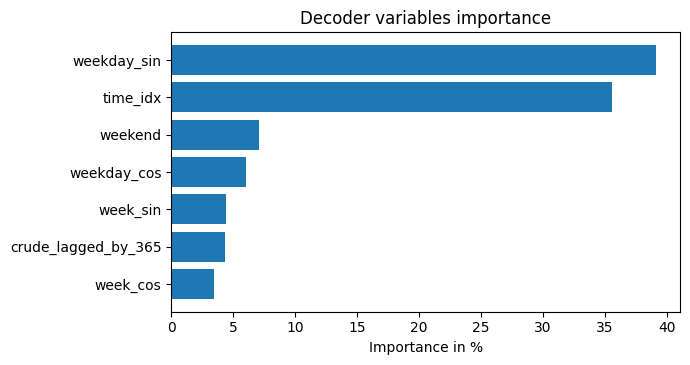

In [34]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)

In [54]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=50,
    max_epochs=3,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.0001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder = False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)


[I 2024-11-24 23:53:37,083] A new study created in memory with name: no-name-cb1c251a-9e1e-4022-955d-2f30be27eaa8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=3` reached.
[I 2024-11-24 23:53:41,502] Trial 0 finished with value: 0.7330571413040161 and parameters: {'gradient_clip_val': 0.010143884421931905, 'hidden_size': 8, 'dropout': 0.26370171379199836, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.010705753529322001}. Best is trial 0 with value: 0.7330571413040161.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=3` reached.
[I 2024-11-24 23:53:46,281] Trial 1

{'gradient_clip_val': 0.010143884421931905, 'hidden_size': 8, 'dropout': 0.26370171379199836, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.010705753529322001}


In [55]:
print(study.best_trial.params)

{'gradient_clip_val': 0.010143884421931905, 'hidden_size': 8, 'dropout': 0.26370171379199836, 'hidden_continuous_size': 8, 'attention_head_size': 3, 'learning_rate': 0.010705753529322001}


In [28]:
os.getcwd()

'/scratch/us2055/Oil_Price/Notebooks'

In [56]:
best_tft = TemporalFusionTransformer.load_from_checkpoint("optuna_test/trial_0/epoch=2.ckpt")


In [57]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


tensor(1.2017)

In [58]:
predictions = best_tft.predict(test_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


tensor(2.9395)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


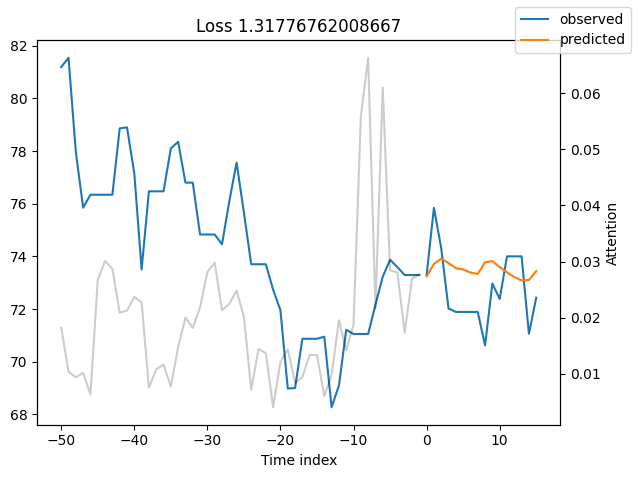

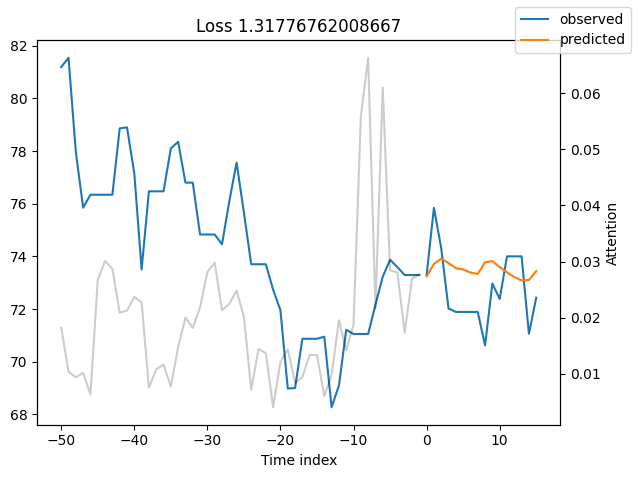

In [59]:
  # plot 10 examples
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx = 0, add_loss_to_title=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


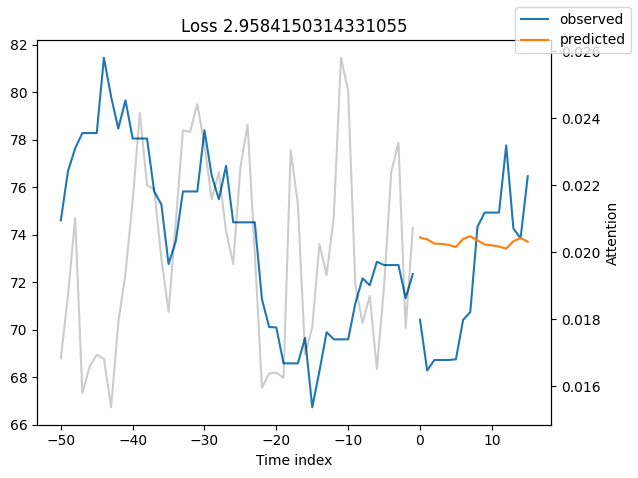

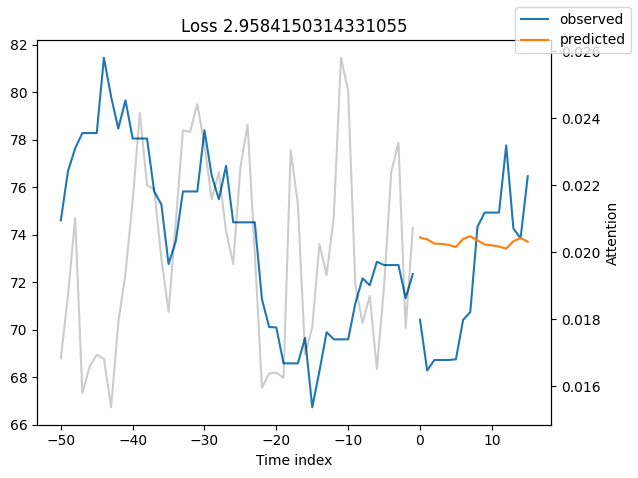

In [60]:
  # plot 10 examples
raw_predictions = tft.predict(test_dataloader, mode="raw", return_x=True)
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx = 0, add_loss_to_title=True)